# Visualization for Delegation Based Lock

In [1]:
@time using DataFrames, CSV

CairoMakie.activate!(type = "svg")


bench = @time CSV.read("output/output.csv", DataFrame)


  2.313746 seconds (1.51 M allocations: 91.179 MiB, 3.49% gc time, 0.24% compilation time)


  4.029756 seconds (798.96 k allocations: 53.995 MiB, 2.20% gc time, 98.93% compilation time: 80% of which was recompilation)

Row,Id,CpuId,ThreadNum,CpuNum,LoopCount,NumAcquire,HoldTime,CombineTime,Locktype
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64?,String
1,0,0,2,32,210738338,253944,2550,16680510840,Flat Combining (SkipList)
2,1,1,2,32,600043724,240957,7239,13063921350,Flat Combining (SkipList)
3,0,0,2,32,206151924,248132,2492,143515350,Flat Combining
4,1,1,2,32,618138668,248125,7454,29760800070,Flat Combining
5,0,0,2,32,410560549,495314,4974,17148013230,Flat Combining Fair
6,1,1,2,32,310141777,124793,3749,10098366690,Flat Combining Fair
7,0,0,2,32,387889276,491350,4935,13330602960,Flat Combining Fair With Combiner Slice
8,1,1,2,32,292939205,123992,3725,12814057650,Flat Combining Fair With Combiner Slice
9,0,0,2,32,349649075,450416,4524,missing,SpinLock


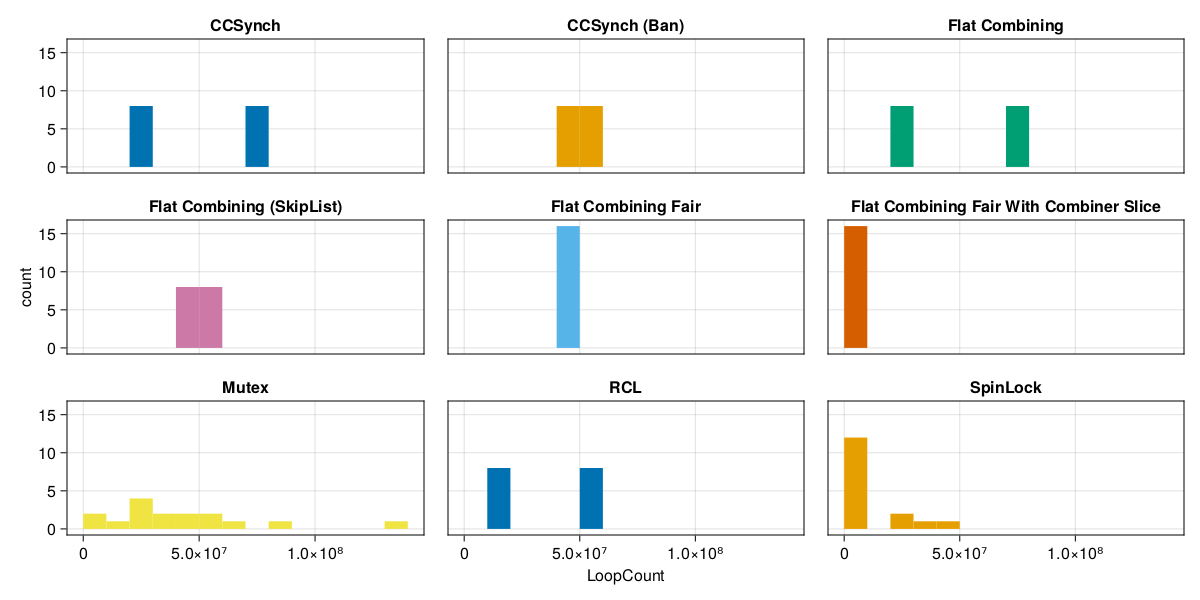

In [23]:
using AlgebraOfGraphics, CairoMakie
using AlgebraOfGraphics: density
using Tidier

fig = Figure(resolution = (1200, 600))

loop_comparison = ((@chain bench begin
        Tidier.@filter(ThreadNum == 16)
end) |> data) * mapping(:LoopCount, layout = :Locktype, color = :Locktype) * histogram(bins = 20)
    
# savefig(loop_comparison, "graphs/loop_comparison.svg")
draw!(fig, loop_comparison)

save("graphs/loop_comparison_per_thread.svg", fig)

fig

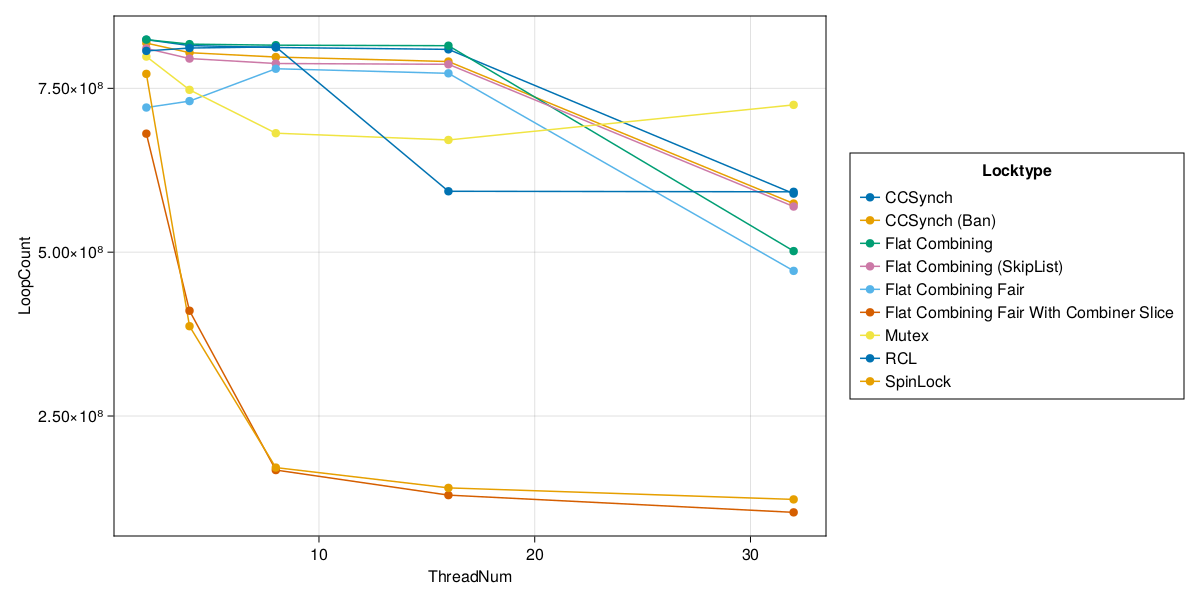

In [3]:
using Tidier
using AlgebraOfGraphics, CairoMakie

bench2 = @chain bench begin
    @group_by(Locktype, ThreadNum)
    @summarise(LoopCount = sum(LoopCount))
    @ungroup
end

plt = data(bench2) * mapping(:ThreadNum, :LoopCount, color = :Locktype) * (visual(Lines) + visual(Scatter))

fig = draw(plt, figure = (resolution=(1200,600),))

save("graphs/loop_comparison.svg", fig)

fig

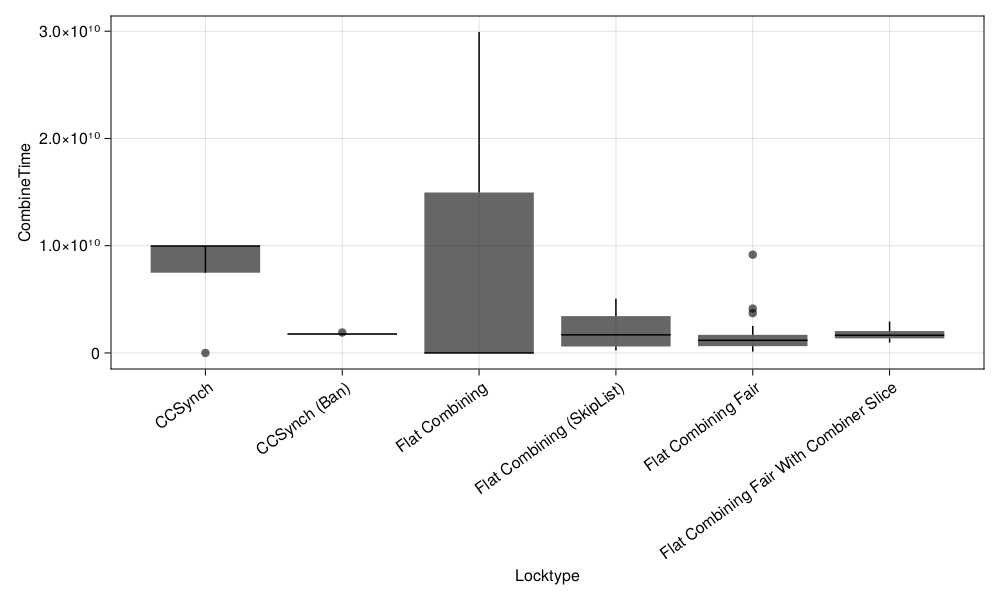

In [22]:
using DataFrames, Tidier, AlgebraOfGraphics, CairoMakie

bench_32thread = @chain dropmissing(bench) begin
    Tidier.@filter(ThreadNum == 16)
end

plt = data(bench_32thread) * mapping(:Locktype, :CombineTime) * visual(BoxPlot)


fig = draw(plt, axis=(xticklabelrotation=pi/5,), figure = (resolution=(1000,600),))

save("graphs/combining_time_box_plot.svg", fig)

fig